# Inference Time

In [ ]:
from dust3r.inference import inference, load_model
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

import time
import numpy as np

model_path = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
device = 'cuda:6'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300

model = load_model(model_path, device)
# load_images can take a list of images or a directory
images = load_images(['croco/assets/Chateau1.png', 'croco/assets/Chateau2.png'], size=512)

In [ ]:
batch = []
for _ in range(100):
    times = []
    t0 = time.time()
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    t1 = time.time()
    times.append(t1 - t0)
    output, ts = inference(pairs, model, device, batch_size=batch_size, return_times=True)
    times += ts
    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']
    # here, view1, pred1, view2, pred2 are dicts of lists of len(2)
    #  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
    # in each view you have:
    # an integer image identifier: view1['idx'] and view2['idx']
    # the img: view1['img'] and view2['img']
    # the image shape: view1['true_shape'] and view2['true_shape']
    # an instance string output by the dataloader: view1['instance'] and view2['instance']
    # pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
    # pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
    # pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

    # next we'll use the global_aligner to align the predictions
    # depending on your task, you may be fine with the raw output and not need it
    # with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
    # if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment
    t0 = time.time()
    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    t1 = time.time()
    times.append(t1 - t0)
    loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

    # retrieve useful values from scene:
    imgs = scene.imgs
    t0 = time.time()
    focals = scene.get_focals()
    poses = scene.get_im_poses()
    pts3d = scene.get_pts3d()
    confidence_masks = scene.get_masks()
    t1 = time.time()
    times.append(t1 - t0)
    batch.append(times)

batch = np.array(batch)
print('Pairing, Encoder, Decoder, Downstream Head')
print(f'batch times: {batch.mean(0)}')
print(f'batch times std: {batch.std(0)}')
print(f'% of time spent in each step: {batch.mean(0) / batch.mean(0).sum() * 100}')

    Pairing         Encoder        Decoder        Head           Scene          Scene Parsing
    17.82us         19.93ms        26.93ms        11.24ms        72.59ms        6.69ms
    0.01%           14.51%         19.59%         8.18%          52.83%         4.87%

    Pairing         Encoder        Decoder        Head           Scene          Scene Parsing
    19.42us         16.71ms        23.73ms        14.48ms        20.95ms        6.98ms
    6.88us          2.81ms         2.23ms         2.51ms         9.37ms         1.19ms
    0.02%           20.17%         28.64%         17.48%         25.28%         8.42%

In [ ]:
0.01 + 14.51 + 19.59 + 8.18 + 52.83 + 4.87

In [ ]:
s = [16.71, 23.73, 14.48]
s = [19.93, 26.93, 11.24]

[i / sum(s) * 100 for i in s]

In [ ]:
sum(s)

# Pre-save Features

In [ ]:
from PIL import Image

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000001.jpg')

In [ ]:
import json

with open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/selected_seqs_train.json') as f:
    train = json.load(f)
with open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/selected_seqs_test.json') as f:
    test = json.load(f)

In [ ]:
train

In [ ]:
test

In [ ]:
[(i, train[i].keys()) for i in train.keys()]

In [ ]:
from jsondiff import diff
diff(train, test)

In [ ]:
import glob

list_1 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.jpg")
list_2 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.npy")
list_3 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.npz")
len(list_1), len(list_2), len(list_3)

In [ ]:
list_1 = [f[:-4] for f in list_1]
list_2 = [f[:-4] for f in list_2]
list_3 = [f[:-4] for f in list_3]

In [ ]:
s = set(list_2)
temp = [x for x in list_1 if x not in s]
print(sorted(temp))
len(temp)

In [ ]:
list_1 == list_2, list_1 == list_3, list_2 == list_3

In [ ]:
list_2


In [ ]:
import os

for i in list_2:
    os.remove(i)
    continue

In [ ]:
import torch
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model

model = AsymmetricCroCo3DStereo(
    pos_embed='RoPE100',
    img_size=(224, 224),
    head_type='linear',
    output_mode='pts3d', 
    depth_mode=('exp', -inf, inf), 
    conf_mode=('exp', 1, inf), 
    enc_embed_dim=192, 
    enc_depth=12, 
    enc_num_heads=3, 
    dec_embed_dim=768, 
    dec_depth=12, 
    dec_num_heads=12)

In [ ]:
train_modules = [model.patch_embed, model.mask_generator, model.rope, model.enc_blocks, model.enc_norm]
train_params = torch.nn.ParameterList([p for m in train_modules for p in m.parameters()])

In [ ]:
opt = torch.optim.Adam(train_params, lr=1e-3)

# Build Model

In [ ]:
import torch
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.inference import load_model

In [ ]:
MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"
MODEL_NEW = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"

CKPT = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
CKPT_KD = "log/train_10/checkpoint-best.pth"
CKPT_NEW = "checkpoints/DUSt3R_ViTSmall_BaseDecoder_512_dpt_kd.pth"

In [ ]:
model = load_model(CKPT, 'cpu')

In [ ]:
model_kd = eval(MODEL_KD)
ckpt_kd = torch.load(CKPT_KD)['model']
print(model_kd.load_state_dict(ckpt_kd, strict=True))

In [ ]:
model_new = eval(MODEL_NEW)

In [ ]:
module_list = ['decoder_embed', 'dec_norm', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
module_list_kd = ['patch_embed', 'mask_generator', 'rope', 'enc_blocks', 'enc_norm', 'adapter']

In [ ]:
for m in module_list:
    getattr(model_new, m).load_state_dict(getattr(model, m).state_dict(), strict=True)
model_new.mask_token = model.mask_token

for m in module_list_kd:
    getattr(model_new, m).load_state_dict(getattr(model_kd, m).state_dict(), strict=True)

In [ ]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismatch found at', key_item_1[0], key_item_2[0])
            else:
                print('Error at', key_item_1[0], key_item_2[0])
            return False
    if models_differ == 0:
        # print('Models match perfectly! :)')
        return True

In [ ]:
for m, k in zip(model_kd.named_children(), model_new.named_children()):
    print(m[0], compare_models(m[1],k[1]), '\n')

In [ ]:
l = [x for x in model_new.named_children() if x[0] != 'adapter']
for m, k in zip(model.named_children(), l):
    print(m[0], compare_models(m[1],k[1]), '\n')
    # except:
    #     print(m[0], "Size Mismatch")

In [ ]:
torch.save(model_new.state_dict(), CKPT_NEW)

In [ ]:
ckpt_new = torch.load(CKPT_NEW)
print(model_kd.load_state_dict(ckpt_new, strict=False))

In [ ]:
def build_model_enc_dec(model_str, device):
    teacher = load_model("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", device)
    teacher.eval()

    model = eval(model_str)
    model.to(device)
    model.eval()

    module_list = ['decoder_embed', 'dec_norm', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
    for m in module_list:
        getattr(model, m).load_state_dict(getattr(teacher, m).state_dict(), strict=True)

    return teacher, model

In [ ]:
teacher, model = build_model_enc_dec(MODEL_NEW, 'cpu')

In [ ]:
l = [x for x in model.named_children() if x[0] != 'adapter']
for m, k in zip(teacher.named_children(), l):
    print(m[0], compare_models(m[1],k[1]), '\n')

In [ ]:
from PIL import Image

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000060.jpg')

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000030.jpg')

In [ ]:
import torch

In [ ]:
w0 = torch.load('log/train_w_0/checkpoint-1.pth', map_location='cpu')['model']
w1 = torch.load('log/train_x_1/checkpoint-2.pth', map_location='cpu')['model']
w2 = torch.load('checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth', map_location='cpu')['model']

In [ ]:
h0 = torch.load('log_kd/log_h/ckpt/iter_2475.pth', map_location='cpu')
h1 = torch.load('log_kd/log_h/ckpt/iter_4950.pth', map_location='cpu')

In [ ]:
for i, j in zip(w2.items(), w0.items()):
    if torch.equal(i[1], j[1]):
        print(i[0], torch.equal(i[1], j[1]))

In [ ]:
w0['model']['mask_token']

In [ ]:
import torch
w = torch.load('log/train_10/checkpoint-last.pth')

In [ ]:
w.keys()

In [ ]:
w['best_so_far']

# Habitat MP3D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import cv2, numpy as np
import matplotlib.pyplot as plt

# i = cv2.imread('/ssd1/wenyan/scannetpp_processed/d6d9ddb03f/depths/DSC05114.png')
i = cv2.imread('/mnt/wenyan/scannetpp_processed/d6d9ddb03f/depths/DSC05114.png')
i = i * 255.0 / i.max()
plt.imshow(i / 255.0, cmap='inferno')

In [ ]:
i.min(), i.max()

# ScanNet++ Splits

In [5]:
import json
import os

In [6]:
BASE_PATH = '/ssd1/wenyan/scannetpp_processed'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    frames = os.listdir(os.path.join(base_path, scene, 'images'))
    return [int(f.split('.')[0].split("DSC")[1].lstrip("0")) for f in frames if f.endswith('.JPG')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [7]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [5]:
from dust3r.datasets import ScanNet

dataset = ScanNet(split='train', ROOT='/ssd1/wenyan/scannetpp_processed', aug_crop=16, mask_bg='rand', resolution=224)

In [6]:
for i in dataset:
    print(i)
    break

[{'img': tensor([[[-0.2941, -0.3647, -0.5059,  ..., -0.3490, -0.3333, -0.2941],
         [-0.2235, -0.3569, -0.4275,  ..., -0.2627, -0.2706, -0.2471],
         [-0.1922, -0.2549, -0.4118,  ..., -0.1451, -0.1765, -0.2157],
         ...,
         [ 0.6941,  0.7098,  0.7020,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.7098,  0.7098,  0.7098,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.7098,  0.7098,  0.7098,  ...,  1.0000,  1.0000,  1.0000]],

        [[-0.4824, -0.5137, -0.6157,  ..., -0.5373, -0.5137, -0.4667],
         [-0.4039, -0.5059, -0.5529,  ..., -0.4510, -0.4431, -0.4039],
         [-0.3647, -0.4039, -0.5373,  ..., -0.3255, -0.3490, -0.3882],
         ...,
         [ 0.4745,  0.4902,  0.4824,  ...,  0.9216,  0.9216,  0.9137],
         [ 0.4902,  0.4902,  0.4902,  ...,  0.9137,  0.9137,  0.9137],
         [ 0.4902,  0.4902,  0.4902,  ...,  0.9137,  0.9137,  0.9137]],

        [[-0.7961, -0.7804, -0.8510,  ..., -0.8431, -0.8039, -0.7333],
         [-0.7412, -0.8039, -0.8118,

# DL3DV Splits

In [8]:
import json
import os

In [9]:
BASE_PATH = '/ssd1/sa58728/dust3r/data/DL3DV-10K/'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    frames = os.listdir(os.path.join(base_path, scene, 'gaussian_splat/images_4'))
    return [int(f.split('.')[0].split("frame_")[1].lstrip("0")) for f in frames if f.endswith('.png')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [10]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [3]:
from dust3r.datasets import DL3DV

dataset = DL3DV(split='train', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', aug_crop=16, mask_bg='rand', resolution=224)

for i in dataset:
    print(i[0]['img'].shape)
    break

torch.Size([3, 224, 224])


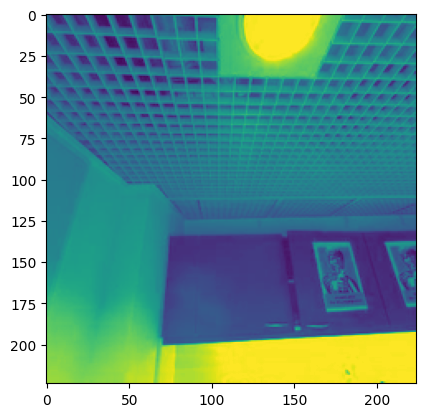

In [7]:
import matplotlib.pyplot as plt

plt.imshow(i[0]['img'][0])

# MegaDepth Splits

In [1]:
import json
import os

In [ ]:
BASE_PATH = '/ssd1/sa58728/dust3r/data/MegaDepth_v1/'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    if scene.endswith('list'):
        return []
    try:
        frames = os.listdir(os.path.join(base_path, scene, 'dense0/imgs/'))
    except:
        frames = os.listdir(os.path.join(base_path, scene, 'dense1/imgs/'))
    return [f.split('.')[0] for f in frames if f.endswith('.jpg')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [ ]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [1]:
from dust3r.datasets import MegaDepth

dataset = MegaDepth(split='train', ROOT='/ssd1/sa58728/dust3r/data/MegaDepth_v1', aug_crop=16, mask_bg='rand', resolution=224)

for i in dataset:
    print(i[0]['img'].shape)
    break

torch.Size([3, 224, 224])


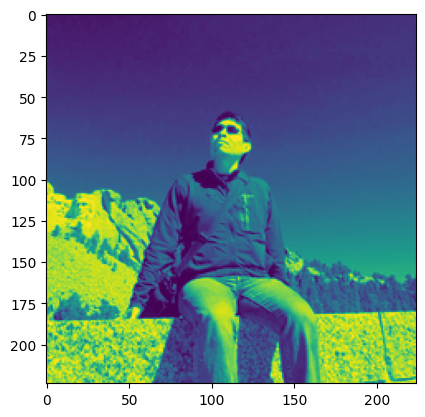

In [2]:
import matplotlib.pyplot as plt

plt.imshow(i[0]['img'][0])